In [1]:
from IPython.core.display import HTML
HTML(r"""
<style>
    * {
        font-family: monospace;
        font-size: 12px;
        line-height: normal;
    }
</style>
""")

In [2]:
from datetime import datetime, timedelta
from typing import List
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import xmltodict

from tabulate import tabulate
import numpy as np
import pandas as pd
import pandasql as psql
import seaborn as sns
from crawler_engine import crawl_url

# Crawl data

In [3]:
def format_url(event_date: datetime):
    return f"https://giavang.pnj.com.vn/history?gold_history_day={str(event_date.day).zfill(2)}" \
        f"&gold_history_month={str(event_date.month).zfill(2)}" \
        f"&gold_history_year={str(event_date.year)}"

today = datetime.now()
print(format_url(event_date=today))

https://giavang.pnj.com.vn/history?gold_history_day=18&gold_history_month=06&gold_history_year=2024


In [4]:
def transform_data(data: str, list_records: List[str], event_date: datetime):
    html_table_pattern = r"<table.*?<\/table>"
    record_by_brand = {}
    yyyymmdd = event_date.strftime("%Y%m%d")
    for matched_string in re.findall(pattern=html_table_pattern, string=data):
        tbl = xmltodict.parse(xml_input=matched_string)
        if len(tbl["table"]["thead"]["tr"]["th"]) == 3 \
            and tbl["table"]["thead"]["tr"]["th"]["#text"] == "Lịch sử giá vàng Hà Nội" \
            and len(tbl["table"]["tbody"]["tr"]) > 1:
            rows = tbl["table"]["tbody"]["tr"][1:]  # Skip header of table
            current_brand = ""
            for row in rows:
                event = row["td"]
                if len(row["td"]) == 4: # data of new brand appears
                    current_brand = event[0]["#text"]
                    event = event[1:]
                buy_price = event[0]["#text"]
                sell_price = event[1]["#text"]
                update_time = event[2]["#text"]
                if not record_by_brand.get(current_brand):
                    record_by_brand[current_brand] = {
                        "event_date": yyyymmdd,
                        "brand": current_brand,
                        "buy_price": buy_price,
                        "sell_price": sell_price,
                        "update_time": update_time,
                    }
                elif record_by_brand[current_brand]["update_time"] < update_time:
                    record_by_brand[current_brand] = {
                        "event_date": yyyymmdd,
                        "brand": current_brand,
                        "buy_price": buy_price,
                        "sell_price": sell_price,
                        "update_time": update_time,
                    }
            break
    if (count := len(record_by_brand.keys())) > 0:
        global audit_record_number
        audit_record_number += count
        list_records.extend([v for _, v in record_by_brand.items()])
    else:
        global audit_nodata_date_number
        audit_nodata_date_number += 1

In [5]:
audit_record_number = 0
audit_nodata_date_number = 0
start_date = datetime(year=2024, month=1, day=1)
# end_date = datetime(year=2023, month=12, day=31)
end_date = datetime.now()
gold_price_data = await crawl_url(start_date=start_date, end_date=end_date, format_url=format_url, transform_data=transform_data,)

In [6]:
if (delta := audit_record_number - len(gold_price_data)) == 0:
    print(f"Number of records is eligible: {len(gold_price_data)}")
    print(f"Number of days having no-data: {audit_nodata_date_number}")
else:
    print(f"Number of records is incorrect: audit_record_number={audit_record_number} vs len_records={len(gold_price_data)}, delta={delta}")

Number of records is eligible: 5804
Number of days having no-data: 555


In [7]:
df_gold_prices = pd.DataFrame.from_dict(gold_price_data).sort_values(by=["event_date", "brand"], ascending=False).reset_index(drop=True)
df_gold_prices.head(n=5)

,event_date,brand,buy_price,sell_price,update_time
0,20240618,SJC,74.980,76.980,18/06/2024 08:09:01
1,20240618,PNJ,73.300,75.000,18/06/2024 08:09:01
2,20240617,SJC,74.980,76.980,17/06/2024 08:13:04
3,20240617,PNJ,73.300,75.000,17/06/2024 08:13:04
4,20240615,SJC,74.980,76.980,15/06/2024 08:09:01


In [8]:
df_gold_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804 entries, 0 to 5803
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   event_date   5804 non-null   object
 1   brand        5804 non-null   object
 2   buy_price    5804 non-null   object
 3   sell_price   5804 non-null   object
 4   update_time  5804 non-null   object
dtypes: object(5)
memory usage: 226.8+ KB


In [9]:
df_gold_prices = df_gold_prices.astype({
    "event_date": int,
    "buy_price": float,
    "sell_price": float,
})
df_gold_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804 entries, 0 to 5803
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   event_date   5804 non-null   int64  
 1   brand        5804 non-null   object 
 2   buy_price    5804 non-null   float64
 3   sell_price   5804 non-null   float64
 4   update_time  5804 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 226.8+ KB


In [10]:
df_gold_prices.head(n=5)

,event_date,brand,buy_price,sell_price,update_time
0,20240618,SJC,74.98,76.98,18/06/2024 08:09:01
1,20240618,PNJ,73.30,75.00,18/06/2024 08:09:01
2,20240617,SJC,74.98,76.98,17/06/2024 08:13:04
3,20240617,PNJ,73.30,75.00,17/06/2024 08:13:04
4,20240615,SJC,74.98,76.98,15/06/2024 08:09:01


In [32]:
df_gold_prices.to_csv(path_or_buf=f"./data/gold_prices/{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}.csv", index=False)

In [11]:
# li_data = []
# li_files = [
#     "./data/gold_prices/20240401-20150101.csv",
#     "./data/gold_prices/20240407-20240401.csv",
#     "./data/gold_prices/20240409-20240408.csv",
# ]
# for i in li_files:
#     li_data.append(pd.read_csv(filepath_or_buffer=i))
# df = pd.concat(li_data, axis=0, ignore_index=True)

In [12]:
# df.head(n=5)

# Visualize data

In [34]:
df_gold_prices = pd.read_csv(filepath_or_buffer=f"./data/gold_prices/{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}.csv")
df_gold_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804 entries, 0 to 5803
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   event_date   5804 non-null   int64  
 1   brand        5804 non-null   object 
 2   buy_price    5804 non-null   float64
 3   sell_price   5804 non-null   float64
 4   update_time  5804 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 226.8+ KB


In [90]:
# print(
#     tabulate(
#         tabular_data=df_gold_prices.query(f"brand == 'SJC' and event_date >= 20240601"),
#         headers="keys",
#         tablefmt="psql",
#         showindex=False,
#     )
# )

In [93]:
# df_gold_prices["year"] = (df_gold_prices["event_date"] / 10 ** 4).astype(int)
# df_gold_prices.head()

In [94]:
# df_gold_prices.query("brand == 'SJC'").groupby(by=["year", "brand"]).agg({
#     "sell_price": ["max", "min", np.ptp,]
# }).sort_values(by="year", ascending=False)

In [95]:
# df_gold_prices.query(f"event_date >= 20240601 and brand == 'SJC'")

## Last 30 days

/var/folders/83/4ks28b950pvgtlp8qx7h3mwc0000gn/T/ipykernel_57355/1634610764.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/var/folders/83/4ks28b950pvgtlp8qx7h3mwc0000gn/T/ipykernel_57355/1634610764.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


<Axes: title={'center': 'Last 30 days'}, xlabel='Date', ylabel='Price'>

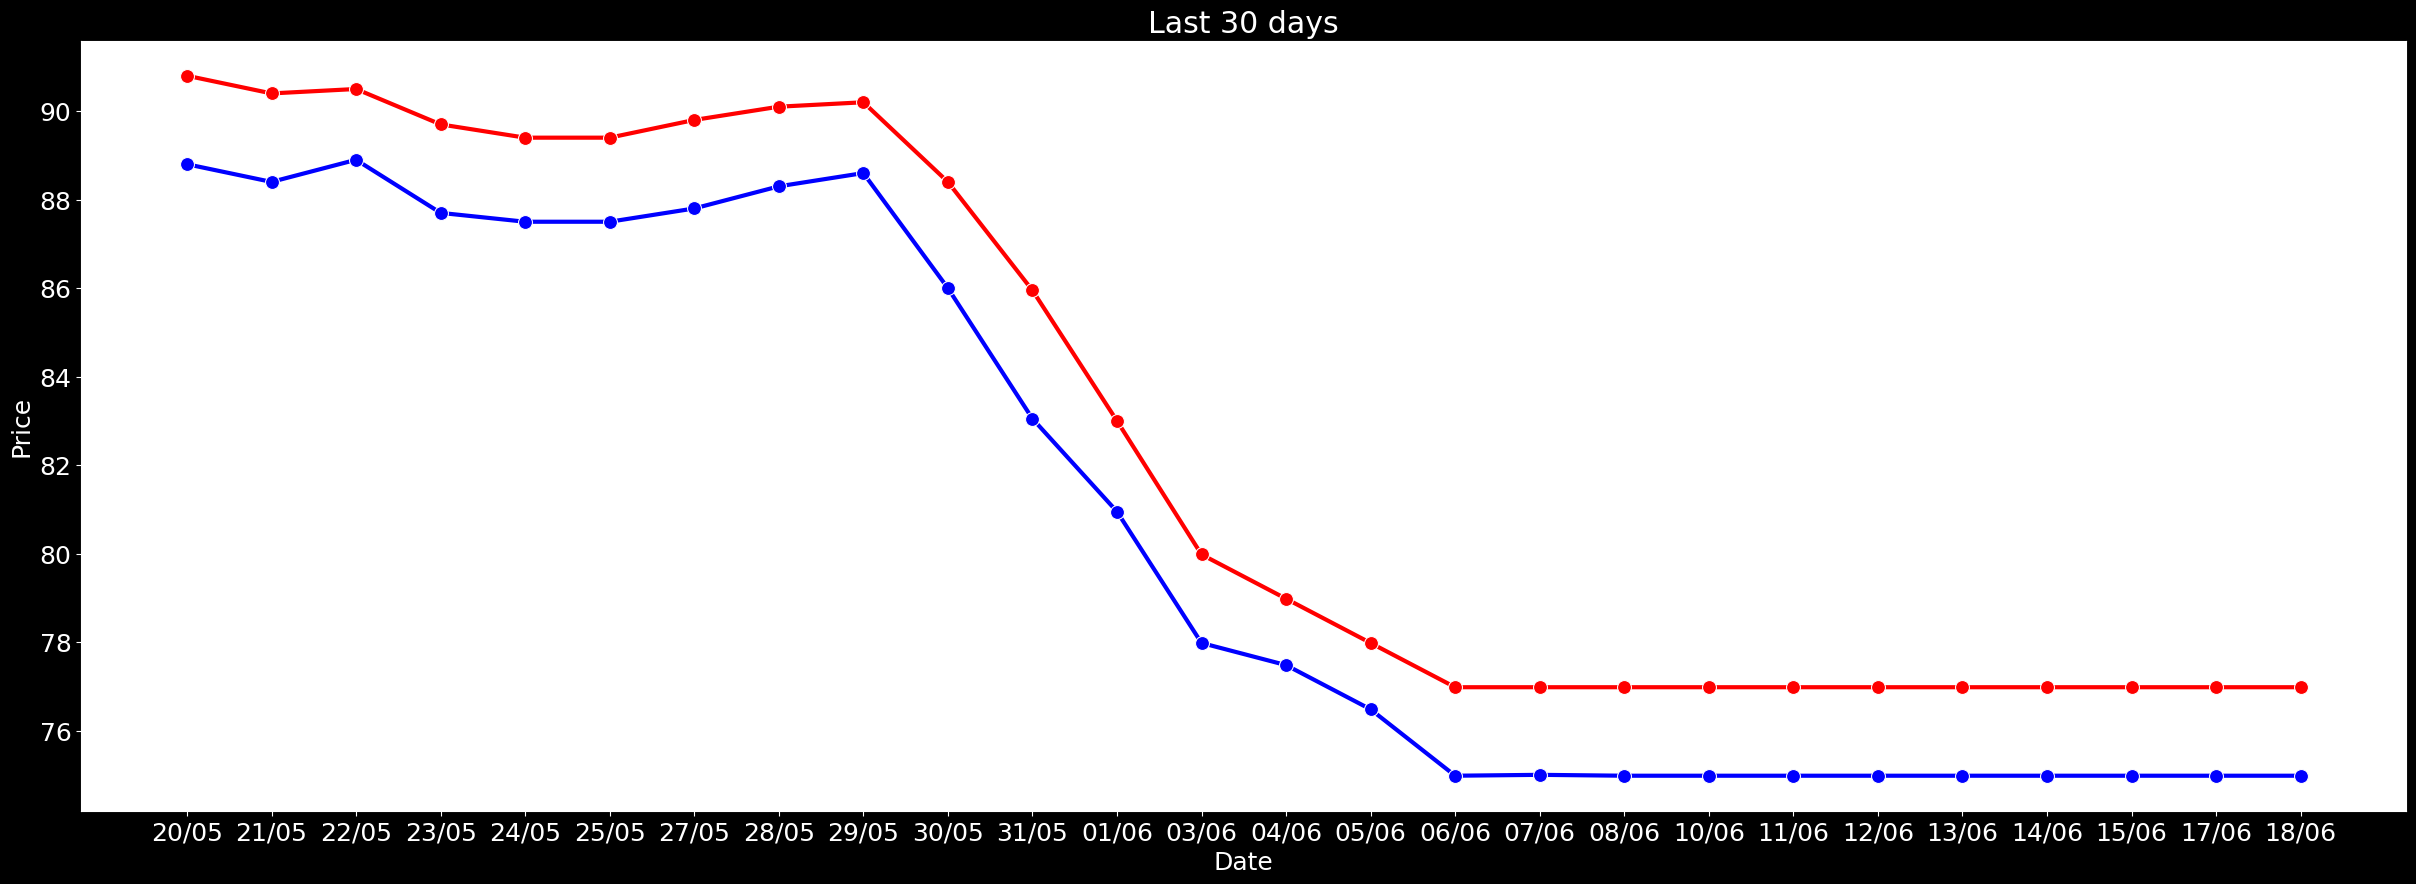

In [106]:
# Last 30 days
mpl.rcParams["font.size"] = 18
query_date = (datetime.today() - timedelta(days=30)).strftime("%Y%m%d")
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_facecolor(color="white")
ax.set_title("Last 30 days")
plt.xlabel("Date")
plt.ylabel("Price")

df_last_30_days = df_gold_prices.query(f"event_date >= {query_date} and brand == 'SJC'").copy(deep=True)
df_last_30_days["date"] = pd.to_datetime(df_last_30_days["event_date"], format="%Y%m%d").dt.strftime("%d/%m")
sns.lineplot(
    x="date",
    y="sell_price",
    # hue="brand",
    palette="muted",
    linewidth=3,
    marker='.',
    markersize=20,
    data=df_last_30_days.sort_values(by=["event_date"]),
    sort=False,
    color="red",
)
sns.lineplot(
    x="date",
    y="buy_price",
    # hue="brand",
    palette="muted",
    linewidth=3,
    marker='.',
    markersize=20,
    data=df_last_30_days.sort_values(by=["event_date"]),
    sort=False,
    color="blue",
)

In [146]:
df_last_30_days[['date', 'brand', 'buy_price', 'sell_price', 'update_time',]].head(n=100)

,date,brand,buy_price,sell_price,update_time
0,18/06,SJC,74.98,76.98,18/06/2024 08:09:01
2,17/06,SJC,74.98,76.98,17/06/2024 08:13:04
4,15/06,SJC,74.98,76.98,15/06/2024 08:09:01
6,14/06,SJC,74.98,76.98,14/06/2024 08:16:44
8,13/06,SJC,74.98,76.98,13/06/2024 08:10:12
10,12/06,SJC,74.98,76.98,12/06/2024 08:19:03
12,11/06,SJC,74.98,76.98,11/06/2024 08:58:04
14,10/06,SJC,74.98,76.98,10/06/2024 08:07:20
16,08/06,SJC,74.98,76.98,08/06/2024 08:14:30
18,07/06,SJC,75.00,76.98,07/06/2024 15:38:01


## Over years

### Handle data

In [147]:
df_gold_prices["year"] = (df_gold_prices["event_date"] / 10 ** 4).astype(int)
# df_gold_prices.head()
df_over_years = df_gold_prices.query("brand == 'SJC'").groupby(by=["year", "brand"]).agg({
    "sell_price": ["max", "min", np.ptp,]
}).sort_values(by="year", ascending=False).copy(deep=True)
df_over_years.head()

sell_price              
                  max    min    ptp
year brand                         
2024 SJC         92.2  74.20  18.00
2023 SJC         79.6  66.50  13.10
2022 SJC         74.0  61.45  12.55
2021 SJC         61.8  54.50   7.30
2020 SJC         61.9  42.80  19.10

In [148]:
df_over_years = df_over_years.reset_index()
df_over_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (year, )           10 non-null     int64  
 1   (brand, )          10 non-null     object 
 2   (sell_price, max)  10 non-null     float64
 3   (sell_price, min)  10 non-null     float64
 4   (sell_price, ptp)  10 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 532.0+ bytes


In [149]:
df_over_years.head()

year brand sell_price              
                     max    min    ptp
0  2024   SJC       92.2  74.20  18.00
1  2023   SJC       79.6  66.50  13.10
2  2022   SJC       74.0  61.45  12.55
3  2021   SJC       61.8  54.50   7.30
4  2020   SJC       61.9  42.80  19.10

### Charts

/var/folders/83/4ks28b950pvgtlp8qx7h3mwc0000gn/T/ipykernel_57355/3261794442.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/var/folders/83/4ks28b950pvgtlp8qx7h3mwc0000gn/T/ipykernel_57355/3261794442.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


<Axes: title={'center': 'Over years'}, xlabel='Year', ylabel='Price'>

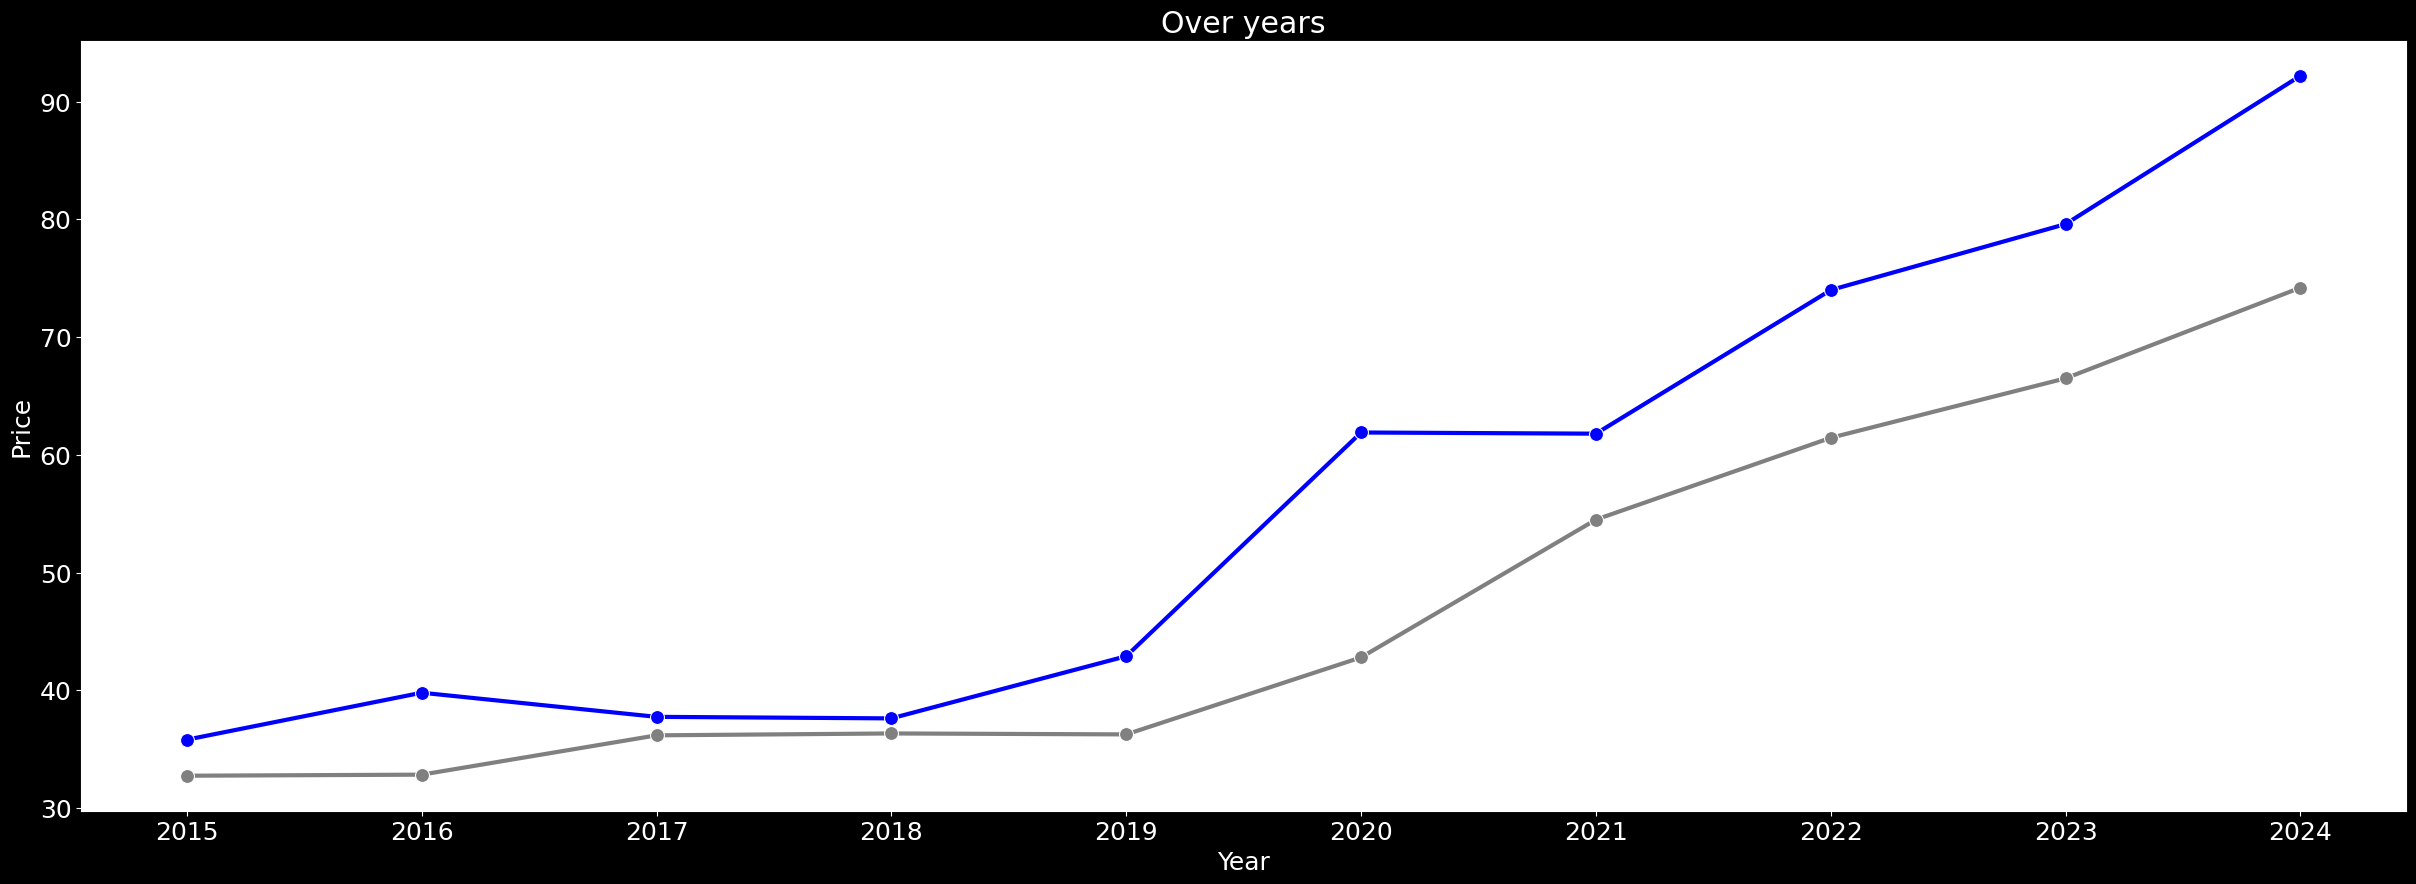

In [152]:
# Over years
mpl.rcParams["font.size"] = 18
query_date = (datetime.today() - timedelta(days=30)).strftime("%Y%m%d")
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_facecolor(color="white")
ax.set_title("Over years")
ax.set_xticks(df_over_years["year"].to_list())
plt.xlabel("Year")
plt.ylabel("Price")

sns.lineplot(
    x="year",
    y=("sell_price", "max"),
    # hue="brand",
    palette="muted",
    linewidth=3,
    marker='.',
    markersize=20,
    data=df_over_years,
    sort=False,
    color="blue",
)
sns.lineplot(
    x="year",
    y=("sell_price", "min"),
    # hue="brand",
    palette="muted",
    linewidth=3,
    marker='.',
    markersize=20,
    data=df_over_years,
    sort=False,
    color="grey",
)

In [143]:
df_over_years.head(n=100)

year brand sell_price              
                     max    min    ptp
0  2024   SJC      92.20  74.20  18.00
1  2023   SJC      79.60  66.50  13.10
2  2022   SJC      74.00  61.45  12.55
3  2021   SJC      61.80  54.50   7.30
4  2020   SJC      61.90  42.80  19.10
5  2019   SJC      42.90  36.26   6.64
6  2018   SJC      37.62  36.34   1.28
7  2017   SJC      37.75  36.18   1.57
8  2016   SJC      39.80  32.84   6.96
9  2015   SJC      35.81  32.75   3.06